# Classification of K-Forrelation Dataset using Structural VQC

**Goals**: Attempt structural encoding as an algorithm for constructing VQC capable of deciding the k-forrelation problem in the limit of small training dataset and with `n_qubits` < `n (length of input bit string`)

In [ ]:
#General Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import pylab as pl
import random

#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.decomposition import PCA

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.extensions import UnitaryGate

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [2]:
# Constant
SEED = 2508
np.random.seed(SEED)

In [3]:
from qiskit.compiler import transpile

## 1. Load the Dataset from Matlab

In [120]:
datafile = loadmat('datasets/n3_k7_data.mat')
datafile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'NEG_dataset', 'POS_dataset', 'None', 'seed', 'test', 'train', 'validation', '__function_workspace__'])

In [122]:
type(datafile['train'])

numpy.ndarray

In [5]:
df_train = pd.DataFrame(datafile['train'])
df_val = pd.DataFrame(datafile['validation'])
df_test = pd.DataFrame(datafile['test'])

X_train = df_train.iloc[:,0:-1].to_numpy()
y_train = df_train.iloc[:,-1].to_numpy()
X_val = df_val.iloc[:,0:-1].to_numpy()
y_val = df_val.iloc[:,-1].to_numpy()
X_test = df_test.iloc[:,0:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [6]:
# Reduce the dimension of the dataset
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [7]:
# Shrink the size of training dataset for the quantum circuit
n_examples = 100 # for both class combined
# Randomly samples the training set for both classes
random.seed(SEED)
rand_pos_ind = random.sample(range(0, 5000), int(n_examples/2))
rand_neg_ind = random.sample(range(5000, 10000), int(n_examples/2))
X_train_small = np.concatenate((X_train[rand_pos_ind],X_train[rand_neg_ind]))
X_train_pca_small = np.concatenate((X_train_pca[rand_pos_ind],X_train_pca[rand_neg_ind]))
y_train_small = np.concatenate((y_train[rand_pos_ind],y_train[rand_neg_ind]))

## 2. Define structural encoder circuit generator

**Description of encoding scheme:**

* Structural encoding using the `CNOT`, `H`, and `T` universal set
* For each K-forrelation instance of given `n`, there are approximately $3^n$ possible arrangements for sequences of `n` gates compiled from the universal set
* (Trials: include or exclude degenerative sequences (e.g., CNOT-H-H degenerates to only CNOT))
* Then, index the selected arrangements to specific boolean function entries (i.e. a dictionary that maps a function instance to one gate sequence)
* To encode each function in the VQC, simply construct the gate sequence corresponding to that sequence instance (from top to bottom, left to right)

**First trial: Include degenerative sequences**

In [57]:
# TODO: generalize CNOT to pair any pair of qubits (increase number of basis gates, there will be multiple entries for CNOT)
# TODO: also return a dictionary from gate_ind --> gate (e.g., 2 --> CNOT(0,1))
def generate_sequences(length_bitstring, n_qubits, n_layers):
    """
    Args:
        length_bitstring [int]: length of input bit strings of the binary functions
        n_qubits [int]: number of qubits in the circuit
        n_layers [int]: number of length_bitstring-gate layers
            e.g., length_bitstring = 3; n_layers = 2 ==> each block has 3 * 2 = 6 basis gates
    Returns:
        sequence_list [list(list(int))] : list of generated sequence according to universial CNOT, H, T gates convention
    """
    sequence_list = []

    for i in range(length_bitstring):
        # randomly sample a sequence made from the set {0,1,..,n_qubits}
        sequence = np.random.choice(n_qubits+1,size=n_qubits*n_layers).tolist()

        # check if the sequence is already in the list of sequence, if so, sample again
        # TODO: this while loop can be expensive, method can be optimized
        while sequence in sequence_list:
            sequence = np.random.choice(n_qubits+1,size=n_qubits*n_layers).tolist()
        sequence_list.append(sequence)
    return sequence_list

In [75]:
test_sequence = generate_sequences(length_bitstring=3,n_qubits=3,n_layers=2)
test_sequence.sort()
print(test_sequence)

[[0, 3, 2, 2, 0, 2], [2, 3, 3, 0, 2, 2], [2, 3, 3, 2, 1, 1]]


In [80]:
print(type(np.array(test_sequence).flatten()))

<class 'numpy.ndarray'>


In [69]:
# Define function to generate basis blocks for encoder circuit
# TODO: generalize function for more than 2 qubits (for the CNOT part)
def generate_unitaries(length_bitstring, n_qubits, n_layers, sequence_list=None):
    """
    Args:
        length_bitstring [int]: length of input bit strings of the binary functions
        n_qubits [int]: number of qubits in the circuit
        n_layers [int]: number of length_bitstring-gate layers
            e.g., length_bitstring = 3; n_layers = 2 ==> each block has 3 * 2 = 6 basis gates

    Returns:
        unitaries_list [list(QuantumCircuit)]: list of `n` unitaries to encode boolean functions
    """
    unitaries_list = []
    if sequence_list is None:
        sequence_list = generate_sequences(length_bitstring, n_qubits, n_layers)
    qubit_index_list = np.arange(n_qubits)
    # each sequence has length n_qubits * n_layers
    for sequence in sequence_list:
        qc = QuantumCircuit(n_qubits)
        for i in range(len(sequence)):
            gate_code = sequence[i]
            qubit_to_apply = i % n_qubits

            # below is hardcode for n = 3, n_qubits = 2, to be changed later
            if gate_code == 0: qc.h(qubit_to_apply)
            elif gate_code == 1: qc.t(qubit_to_apply)
            else:
                cx_target_list = np.delete(qubit_index_list,qubit_to_apply)
                qc.cx(qubit_to_apply,cx_target_list[gate_code-2])
        unitaries_list.append(qc)

    return unitaries_list, sequence_list

In [72]:
test_unitary_list, test_sequences = generate_unitaries(length_bitstring=3,n_qubits=4,n_layers=1)
print(test_unitary_list)
test_sequences

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2025C0610>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B2025C0B50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001B205712880>]


[[0, 2, 4, 1], [0, 0, 3, 2], [0, 0, 3, 1]]

In [12]:
# Define a function to encode a boolean function into a unitary
def unitary_from_func(unitaries_list,func_vec):
    """
    Args:
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences
        func_vec [np.array]: a vector that encodes a boolean function
    Returns:
        func_encoder [QuantumCircuit]: Unitary that encodes the given function
    """
    n_qubit = unitaries_list[0].width()
    func_encoder = QuantumCircuit(n_qubit)
    sig_bit_indices = np.nonzero(func_vec)[0].astype(int)
    for sig_bit_index in sig_bit_indices:
        func_encoder.compose(unitaries_list[sig_bit_index],qubits=range(n_qubit),inplace=True)

    return func_encoder

In [13]:
# Define a function to generate the encoder circuit for an instance of k-forrelation (one example)
def generate_encoder(unitaries_list, kf_instance, n):
    """
    Args:
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences
        kf_instance [np.array]: a k-forrelation instance
        n [int] : length of input bit string in the example
    Returns:
        encoder [QuantumCircuit]: encoder for the input instance
    """
    n_qubit = unitaries_list[0].width()
    func_vec_list = np.array_split(kf_instance,len(kf_instance)/n)
    encoder = QuantumCircuit(n_qubit)
    # TODO: implement different choices of separation (H, barrier, entanglement, etc.)
    encoder.h(range(n_qubit))

    for func_vec in func_vec_list:
        encoder.compose(unitary_from_func(unitaries_list,func_vec),qubits=range(n_qubit),inplace=True)
        encoder.h(range(n_qubit))
        encoder.barrier()

    return encoder

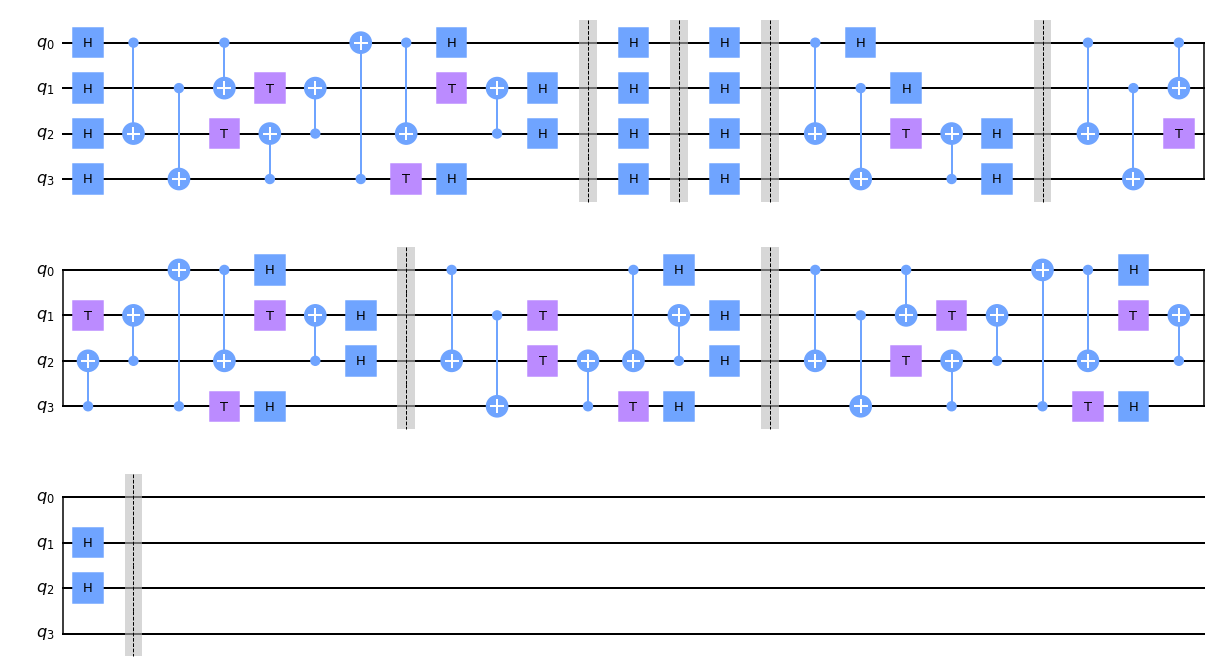

In [61]:
test_encoder = generate_encoder(test_unitary_list,X_train_small[0],3)
test_encoder.draw('mpl')

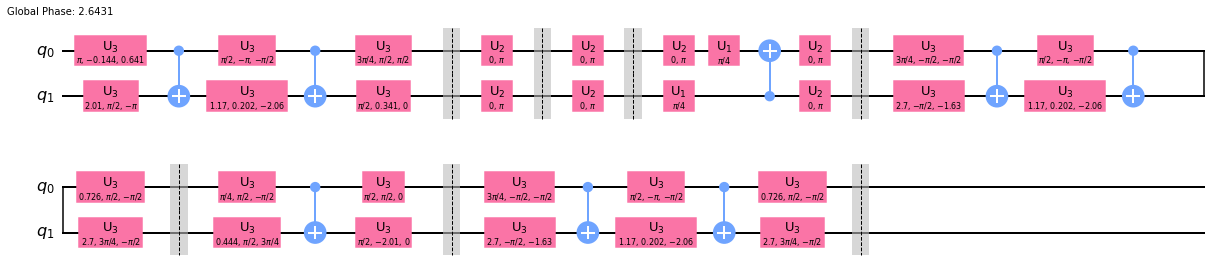

In [15]:
# visualize transpiled (optimized) circuit
test_encoder_trs = transpile(test_encoder,optimization_level=3)
test_encoder_trs.decompose().draw('mpl')

In [62]:
def prepare_all_encoders(data_mat,length_bitstring,unitaries_list):
    """
    Args:
        data_mat [np.array]: data storage matrix of size (m_examples x dim)
        n [int] : length of input bit string in the examples
        unitaries_list [list(QuantumCircuit)]: list of unitaries generated from randomly sampled sequences

    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoders (one for each example in the dataset)
    """
    all_encoders = []
    all_encoders.extend([generate_encoder(unitaries_list,kf_instance,length_bitstring) for kf_instance in data_mat])
    return all_encoders

In [63]:
all_encoders = prepare_all_encoders(X_train_small,3,test_unitary_list)

Circuit: 45


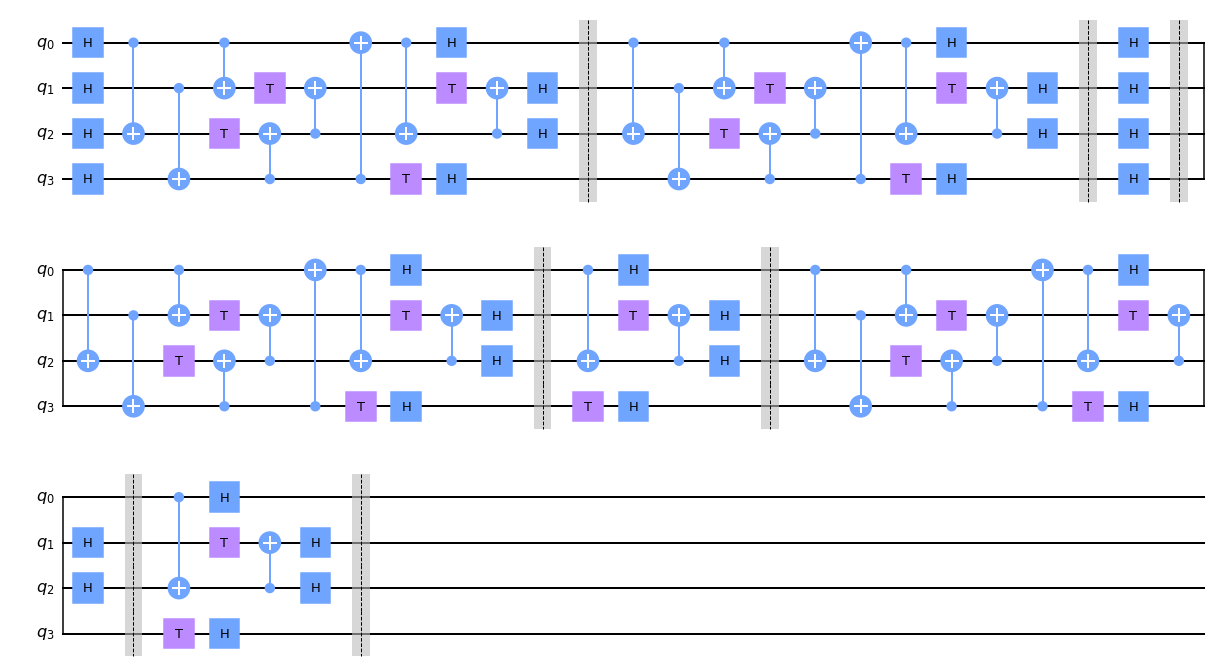

In [64]:
cir_ind = np.random.randint(100)
print('Circuit:',cir_ind)
all_encoders[cir_ind].draw('mpl')

## 3. Define simple ansatz

Simple rotation ansatz to use with the structural encoding circuits:
* R(y) gates for each qubits
* Two Locals

In [19]:
def ansatz_ry(n_qubits,_):
    """
    Args:
        n_qubits [int]: number of qubits in the circuit

    Returns:
    """
    params = ParameterVector('w',n_qubits)
    ansatz = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        ansatz.ry(params[i],i)
    return ansatz, params

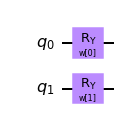

In [20]:
ansatz_1,_ = ansatz_ry(2,_)
ansatz_1.draw('mpl')

In [21]:
from qiskit.circuit.library import TwoLocal
def ansatz_two_locals(n_qubits,reps):
    """
    Args:
        n_qubits:
        reps:
    Returns:
    """
    ansatz = TwoLocal(num_qubits=n_qubits,entanglement='linear',rotation_blocks='ry',
                      entanglement_blocks='cx',reps=reps)
    return ansatz, ansatz.parameters

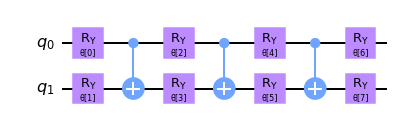

In [22]:
ansatz_2,_ = ansatz_two_locals(2,3)
ansatz_2.decompose().draw('mpl')

In [65]:
def prepare_all_circuits(ansatz_generator,all_encoders,reps,params_values):
    """

    Args:
        ansatz_generator [function]: function to create parameterized ansatz
        all_encoders [list(QuantumCircuit)]: list of all encoders (one for each example in the dataset)
        reps [int]: number of repetition of the ansatz
        params_values [array-like]: values for the parameters

    Returns:
        all_circuits [list(QuantumCircuit)]: list of all circuit for VQC (one for each example)
    """
    all_circuits = []
    n_qubits = all_encoders[0].num_qubits
    ansatz, ansatz_params = ansatz_generator(n_qubits,reps)
    ansatz_params_dict = {param:value for (param,value) in zip(ansatz_params,params_values)}
    binded_ansatz = ansatz.bind_parameters(ansatz_params_dict)
    all_circuits.extend([encoder.compose(binded_ansatz) for encoder in all_encoders])

    return all_circuits

In [66]:
all_circuits = prepare_all_circuits(ansatz_ry,all_encoders,_,[1,1])

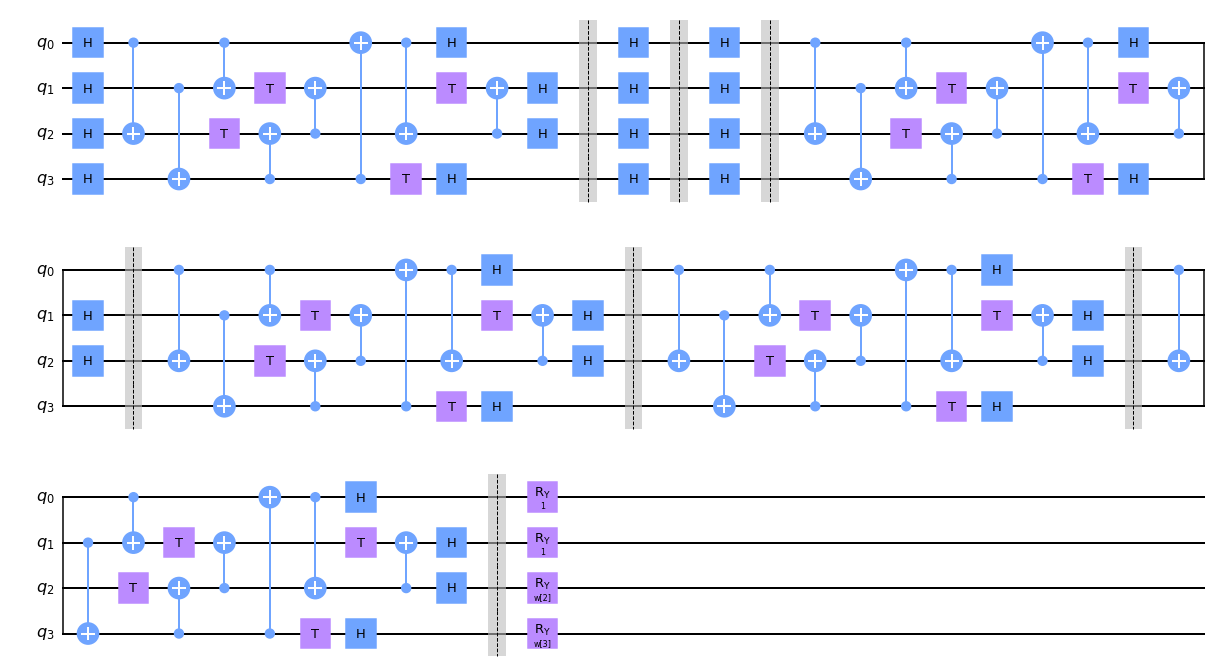

In [67]:
all_circuits[28].draw('mpl')

## 4. Decision rule and cost function

Potential decision rules:
1. Probability of getting bit string 0 (or, expectation value of $|0^{\otimes n} \rangle \langle 0^{\otimes n}|$)
2. Expectation value of $Z^{\otimes n}$ measurement operator

### 4.1. Probability of getting bit string 0

In [26]:
# Define a function to take in all execution results from backend and translate to probability of bit string 0
def get_prob_zeros(all_results):
    prob_zeros = []
    for i in range(len(all_results.results)):
        prob_zeros.append(np.absolute(all_results.get_statevector(i)[0])**2)
    return np.array(prob_zeros)

In [105]:
# Define a function to convert all expectation_vals to a single cross-entropy cost
def eval_cost_cross_ent(prob_zeros, true_labels):
    """
    Args:
        prob_zeros [np.array] : Values between 0 and 1 (probability of measuring the zero bit string)
        true_labels [np.array]: Values either 0 or 1

    Return:
        [np.array] The computed cost of the instance

    """
    m = len(prob_zeros) # --> number of data points
    prob_zeros = prob_zeros.reshape((m,1))
    # TODO: account for log(0) in cost computation
    cost = -np.dot(1-true_labels, np.log(1-prob_zeros)) - np.dot(true_labels, np.log(prob_zeros))
    return float(cost) if not math.isnan(cost) else 10e5

In [28]:
qinst = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [29]:
all_results = qinst.execute(all_circuits)
prob_zeros = get_prob_zeros(all_results)

In [30]:
print(prob_zeros)

[0.08209107 0.00628286 0.53157111 0.03940837 0.17974872 0.00628286
 0.31081328 0.25907291 0.15595182 0.04782864 0.23977012 0.03661165
 0.40759521 0.85807443 0.26673397 0.00910943 0.03963225 0.25
 0.3196646  0.11338207 0.1957817  0.15185723 0.08783469 0.11939686
 0.07298165 0.38507558 0.15587609 0.02267564 0.38507558 0.2058981
 0.78829247 0.82994495 0.18957743 0.10350447 0.61419933 0.02449069
 0.10717276 0.20202313 0.33121955 0.08309822 0.17957702 0.38507558
 0.34941342 0.7091055  0.67024001 0.5123861  0.25700368 0.38197711
 0.6985141  0.44511747 0.11939686 0.16149082 0.12102038 0.07958639
 0.03119223 0.17821907 0.15991631 0.24640851 0.4267767  0.27058667
 0.11147169 0.08319395 0.23794967 0.00534397 0.43072356 0.11326795
 0.24027543 0.19253779 0.80833046 0.17806564 0.39875246 0.15595182
 0.26799141 0.15185726 0.1967604  0.06130855 0.05663244 0.21162999
 0.0353812  0.22638943 0.00534682 0.36366218 0.03963225 0.49021166
 0.06306581 0.06104565 0.0921008  0.21350918 0.16346951 0.39875246
 0

In [31]:
print('Cost:', eval_cost_cross_ent(prob_zeros,y_train_small))

Cost: 102.42591891365059


## 5. Train VQC

In [32]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, ADAM
from activity_1_utils import spsa_optimizer_callback
from activity_1_figure_utils import history_figure
import time

### 5.1. VQC with probability of bit string 0 as decision factor

In [203]:
def train_VQC(optimizer,ansatz_generator,eval_cost_func,quantum_instance,x_train,y_train,length_bitstring,n_qubits,depth,ansatz_reps,initial_point):
    """

    Args:
        optimizer [qiskit.algorithms.optimizers] : optimizer to use for learning the params
        eval_cost_func [function] : a function to calculate the cost of a training instance
        quantum_instance [QuantumInstance] : quantum instance with backend to execute the circuits
        x_train [np.array] : training dataset, examples along rows
        y_train [np.array] : correct label vector
        length_bitstring [int] : length of input bit string
        n_qubits [int]: number of qubits for VQC
        depth [int]: number of layers for each function encoder
        initial_point [list(int)] : initial values of the parameters

    Returns:
    """
    n = length_bitstring
    unitaries_list, construction_sequences = generate_unitaries(n,n_qubits,depth)
    all_encoders = prepare_all_encoders(x_train,n,unitaries_list)
    n_params = len(initial_point)

    def cost_func(ansatz_vals):
        all_circuits = prepare_all_circuits(ansatz_generator,all_encoders,ansatz_reps,ansatz_vals)
        all_results = quantum_instance.execute(all_circuits)
        prob_zeros = get_prob_zeros(all_results)
        return eval_cost_func(prob_zeros,y_train)

    learned_params, loss, nfev = optimizer.optimize(n_params,cost_func,initial_point=initial_point)

    return learned_params, loss, nfev, (unitaries_list,construction_sequences)

In [ ]:
t0 = time.time()

train_history1 = []
optimizer = SPSA(maxiter = 50, callback= lambda n, p, v, ss, sa: spsa_optimizer_callback(n, p, v, ss, sa, train_history1))
ansatz_generator = ansatz_two_locals
eval_cost_func = eval_cost_cross_ent
vqc_qinst = QuantumInstance(Aer.get_backend('statevector_simulator'))
length_bitstring = 3
n_qubits = 2
depth = 2
ansatz_reps = 2
# initial_point = [0,]*n_qubits # ---> for ansatz_ry
initial_point = [0,]*n_qubits*(ansatz_reps + 1) # ---> for ansatz_two_local

learned_params, loss, nfev, encoder_instruction = train_VQC(optimizer,ansatz_generator,eval_cost_func,vqc_qinst,X_train_small,y_train_small,
                                                  length_bitstring,n_qubits,depth, ansatz_reps,initial_point)

fig = history_figure(train_history1)
fig.show()
print(learned_params)
print(f'{time.time() - t0:.2f} sec')

### 5.2. Bayesian Optimization

In [33]:
# from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

In [ ]:
# Define a custom kernel to be used for GP in BO
# implement later

In [84]:
def callback_BO(res):
    """
    Args:
        res [OptimizeResult]: scipy object containing the current status of BO
    """
    last_location = res.x_iters[-1]
    # n_intr = res.nit
    cost_min = res.fun
    # print(f'----Last location: {last_location} ; Current vqc min: {cost_min}')

In [85]:
def callback_BO_blueprint(res):
    last_location = res.x_iters[-1]
    cost_min = res.fun
    print(f'Last blueprint: {last_location} ; Current blueprint min: {cost_min}')

In [73]:
def train_VQC_BO(bounds,n_calls,n_initial_points,xi,ansatz_generator,eval_cost_func,quantum_instance,x_train,y_train,
                 length_bitstring,n_qubits,n_layers,ansatz_reps,initial_point,all_encoders=None):
    """

    Args:
        bounds:
        n_calls:
        n_initial_points:
        xi:
        ansatz_generator:
        eval_cost_func [function] : a function to calculate the cost of a training instance
        quantum_instance [QuantumInstance] : quantum instance with backend to execute the circuits
        x_train [np.array] : training dataset, examples along rows
        y_train [np.array] : correct label vector
        length_bitstring [int] : length of input bit string
        n_qubits [int]: number of qubits for VQC
        depth [int]: number of layers for each function encoder
        ansatz_reps:
        initial_point [list(int)] : initial values of the parameters

    Returns:
    """

    unitaries_list = None
    construction_sequences = None
    if all_encoders is None:
        unitaries_list, construction_sequences = generate_unitaries(length_bitstring,n_qubits,n_layers)
        all_encoders = prepare_all_encoders(x_train,length_bitstring,unitaries_list)

    def cost_func(ansatz_vals):
        all_circuits = prepare_all_circuits(ansatz_generator,all_encoders,ansatz_reps,ansatz_vals)
        all_results = quantum_instance.execute(all_circuits)
        prob_zeros = get_prob_zeros(all_results)
        return eval_cost_func(prob_zeros,y_train)

    # BO using default Matern kernel to optimize the parameters of the ansatz
    bo_results = gp_minimize(cost_func,bounds,
                             n_calls=n_calls,                   # function evaluation budget (including calculations of initial points)
                             n_initial_points=n_initial_points, # number of initial function evaluations, before regression using GP
                             callback=callback_BO,
                             acq_func='EI',acq_optimizer='lbfgs',
                             n_restarts_optimizer=5, # number of repeats (i.e. choosing different initialization) for optimization of acq_func
                             xi=xi,x0=initial_point)

    # extract final results
    learned_params = bo_results.x
    min_val = bo_results.fun

    return learned_params, min_val, (all_encoders, unitaries_list, construction_sequences)

In [99]:
def format_blueprint(input_list,length_bitstring):
    return [input_list[i:i+length_bitstring] for i in range(0, len(input_list),length_bitstring)]

In [98]:
format_blueprint([0,1,2,3,4,5],3)

[[0, 1, 2], [3, 4, 5]]

In [118]:
# Bayesian Optimization for circuit blueprint
# each
def train_blueprint_BO(bounds_vqc,n_calls_blueprint,n_calls_vqc,n_initial_points_vqc,xi_vqc,xi_blueprint, ansatz_generator,eval_cost_func,quantum_instance,
                       x_train,y_train, length_bitstring,n_qubits,n_layers,ansatz_reps,initial_point_vqc):

    # constants
    bounds_blueprint = [(0,n_qubits),]*(length_bitstring * n_qubits * n_layers)
    n_initial_points_blueprint = 3

    # Function that takes in a vector of length length_bitstring * n_qubits * n_layers and return the corresponding lost
    learned_params = None
    min_val=10e5
    def cost_func_structure(blue_print):
        """
        Args:
            blue_print [list(float)]: a vector that encodes construction instruction for the unitary blocks
        Returns:
            min_val [float]: minimum cost value for VQC based on the given blueprint
        """
        global min_val
        # Round and split blue_print to create sequence list
        sequence = format_blueprint(blue_print,length_bitstring)
        print(f'Optimizing blueprint: {sequence} -- min val: {min_val}')

        # Create all encoders and pass into another BO for training the VQC
        unitaries_list,_ = generate_unitaries(length_bitstring,n_qubits,n_layers,sequence_list=sequence)
        all_encoders = prepare_all_encoders(x_train,length_bitstring,unitaries_list)
        ansatz_params,current_min,_ = train_VQC_BO(bounds_vqc,n_calls_vqc,n_initial_points_vqc,xi_vqc,ansatz_generator,eval_cost_func,quantum_instance,
                                     x_train,y_train,length_bitstring,n_qubits,n_layers,ansatz_reps,initial_point_vqc,all_encoders=all_encoders)

        # if current min_val is the smallest so far, also record the learned params
        if current_min < min_val:
            learned_params = ansatz_params
            min_val = current_min
        return current_min

    # Initialize blueprint (not necessary)
    # BO using default Matern kernel to optimize the structure of the ansatz
    bo_results = gp_minimize(cost_func_structure,bounds_blueprint,
                             n_calls=n_calls_blueprint,
                             callback=callback_BO_blueprint,
                             n_initial_points=n_initial_points_blueprint,
                             acq_func='EI',acq_optimizer='lbfgs',
                             n_restarts_optimizer=3,
                             xi=xi_blueprint)

    # extract best blueprint
    best_blueprint = format_blueprint(bo_results.x,length_bitstring)
    print(f'min val: {min_val}')
    return best_blueprint, learned_params, min_val

In [ ]:
t0 = time.time()

ansatz_generator = ansatz_two_locals
eval_cost_func = eval_cost_cross_ent
vqc_qinst = QuantumInstance(Aer.get_backend('statevector_simulator'))
length_bitstring = 3
n_qubits = 2
depth = 2
ansatz_reps = 2
n_calls = 20
n_initial_points = 2
xi = 0.1 # exploration-exploitation trade-off (higher xi --> more exploration)
# initial_point = [0,]*n_qubits # ---> for ansatz_ry
initial_point = [0,]*n_qubits*(ansatz_reps + 1) # ---> for ansatz_two_local
bounds = [(0.0,2*np.pi),]*len(initial_point)

learned_params, cost_history, encoder_instructions = train_VQC_BO(bounds,n_calls,n_initial_points,xi,ansatz_generator,eval_cost_func,
                                                                 vqc_qinst,X_train_small,y_train_small,length_bitstring,n_qubits,depth,
                                                                 ansatz_reps,initial_point)

print(learned_params)
print(f'{time.time() - t0:.2f} sec')
print(cost_history)

In [123]:
t0 = time.time()

n_calls_blueprint = 10
n_calls_vqc = 10
n_initial_points_vqc = 2
xi_vqc = 0.1
xi_blueprint = 0.1
ansatz_generator = ansatz_two_locals
eval_cost_func = eval_cost_cross_ent
vqc_qinst = QuantumInstance(Aer.get_backend('statevector_simulator'))
length_bitstring = 3
n_qubits = 3
n_layers = 1
ansatz_reps = 2
# initial_point_vqc = [0,]*n_qubits # ---> for ansatz_ry
initial_point_vqc = [0,]*n_qubits*(ansatz_reps + 1) # ---> for ansatz_two_local
bounds_vqc = [(0.0,2*np.pi),]*len(initial_point_vqc)


best_blueprint, learned_params, min_val = train_blueprint_BO(bounds_vqc,n_calls_blueprint,n_calls_vqc,n_initial_points_vqc,xi_vqc,xi_blueprint, ansatz_generator,
                                                             eval_cost_func,vqc_qinst, X_train_small,y_train_small,
                                                             length_bitstring,n_qubits,n_layers,ansatz_reps,initial_point_vqc)

print(best_blueprint)
print(f'{time.time() - t0:.2f} sec')

In [115]:
min_val

1000000.0

## 6. Evaluate performance

### 6.1. Evaluation for structural encoding with probability of 0 as decision criterion

In [48]:
# Define function that takes in a k-forrelation test set, learned params and evaluate performance on the dataset
def eval_performance(x_test,y_test,learned_params,ansatz_reps,ansatz_generator,unitaries_list,bitstring_length,quantum_instance):
    all_encoders = prepare_all_encoders(x_test,bitstring_length,unitaries_list)
    all_circuits = prepare_all_circuits(ansatz_generator,all_encoders,ansatz_reps,learned_params)
    all_results = quantum_instance.execute(all_circuits)
    prob_zeros = get_prob_zeros(all_results)
    predictions = (prob_zeros > 0.5).astype(int)
    average_accuracy = sum((predictions == y_test).astype(int)) / len(y_test)
    return average_accuracy

In [52]:
# ansatz_reps =
train_fit = eval_performance(X_train_small, y_train_small, learned_params, ansatz_reps, ansatz_generator, encoder_instructions[1], 3, vqc_qinst)
print(train_fit)

0.51


In [ ]:
encoder_instructions